# I. Dẫn nhập

Mô hình Black–Scholes–Merton model, thường được viết tắt là BSM, là một trong những mô hình nền tảng quan trọng nhất trong lĩnh vực tài chính định lượng hiện đại.

Mô hình này được phát triển vào đầu những năm 1970 bởi ba nhà nghiên cứu: Fischer Black, Myron Scholes và Robert C. Merton. Bài báo gốc đăng năm 1973 đã đặt nền móng cho lý thuyết định giá quyền chọn hiện đại, tạo ra một bước ngoặt lớn trong cách giới tài chính hiểu và giao dịch các công cụ phái sinh.

Điểm cốt lõi của mô hình BSM là đưa ra cách định giá lý thuyết cho quyền chọn không dựa vào kỳ vọng tăng giá hay giảm giá của tài sản cơ sở, mà dựa vào biến động của nó. Mô hình này sử dụng lập luận không có cơ hội arbitrage, kết hợp với việc xây dựng một danh mục phòng hộ delta để loại bỏ rủi ro hướng giá. Từ đó, giá quyền chọn được xác định duy nhất thông qua các yếu tố như giá tài sản cơ sở, thời gian đáo hạn, lãi suất phi rủi ro và độ biến động.


In [149]:
"""
Black–Scholes–Merton Model: Numerical Illustration
--------------------------------------------------
Các đoạn mã minh họa cho bài giảng mô hình BSM (giữ nguyên cấu trúc bản cũ, tối ưu hoá trình bày).
Credit: https://github.com/letrinhandn
"""

from __future__ import annotations

import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# ==== Cấu hình hiển thị ====
USE_TEX = False  # Đặt True nếu máy bạn có LaTeX để chữ công thức mượt hơn
plt.style.use("seaborn-v0_8")
sns.set_context("talk")
if USE_TEX:
    from matplotlib import rc
    rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
    rc("text", usetex=True)

# ==== Thông số mô hình (giữ nguyên spirit bản cũ) ====
S0 = 100.0       # Giá tài sản ban đầu
K = 100.0        # Strike
r = 0.05         # Lãi suất phi rủi ro
q = 0.0          # Tỷ suất cổ tức
sigma = 0.2      # Volatility
T = 1.0          # Thời gian đáo hạn (năm)

steps = 252      # Số bước mô phỏng (số ngày)
paths = 2000     # Số đường mô phỏng (dùng cho thống kê/histogram)
N_PLOT = 5       # Số đường đem ra vẽ minh họa

dt = T / steps
time = np.linspace(0.0, T, steps + 1)

EPS = 1e-12      # Đệm tránh chia cho 0
RNG_SEED = 42    # Seed tái lập kết quả


def _tau(T: float, t: float | np.ndarray) -> np.ndarray:
    """Thời gian còn lại đến đáo hạn, cắt dưới bởi 0."""
    return np.maximum(T - t, 0.0)

def _d1_d2(S, K, r, q, sigma, tau):
    """Tính d1, d2 với xử lý ổn định số khi tau→0."""
    tau_safe = np.maximum(tau, EPS)
    with np.errstate(divide="ignore", invalid="ignore"):
        d1 = (np.log(np.asarray(S) / K) + (r - q + 0.5 * sigma**2) * tau_safe) / (sigma * np.sqrt(tau_safe))
    d2 = d1 - sigma * np.sqrt(tau_safe)
    return d1, d2

def option_price(S, K, T, r, q, sigma, t, cp: str = "Call"):
    """
    Giá option kiểu Châu Âu theo BSM.
    cp ∈ {'Call','Put'}.
    Ổn định số tại đáo hạn: trả về giá nội tại khi tau≈0.
    """
    tau = _tau(T, t)
    d1, d2 = _d1_d2(S, K, r, q, sigma, tau)

    disc_r = np.exp(-r * tau)
    disc_q = np.exp(-q * tau)

    call = np.asarray(S) * disc_q * ss.norm.cdf(d1) - K * disc_r * ss.norm.cdf(d2)
    put  = K * disc_r * ss.norm.cdf(-d2) - np.asarray(S) * disc_q * ss.norm.cdf(-d1)

    # Xử lý tại đáo hạn
    intrinsic_call = np.maximum(np.asarray(S) - K, 0.0)
    intrinsic_put  = np.maximum(K - np.asarray(S), 0.0)
    is_maturity = tau <= 1e-10

    if cp.lower().startswith("c"):
        out = np.where(is_maturity, intrinsic_call, call)
    else:
        out = np.where(is_maturity, intrinsic_put, put)
    return out

def delta(S, K, T, r, q, sigma, t, cp: str = "Call"):
    """Delta BSM (không xác định đúng tại ATM, tau=0 — dùng công thức giới hạn)."""
    tau = _tau(T, t)
    d1, _ = _d1_d2(S, K, r, q, sigma, tau)
    disc_q = np.exp(-q * tau)
    if cp.lower().startswith("c"):
        return disc_q * ss.norm.cdf(d1)
    return disc_q * ss.norm.cdf(d1) - 1.0

def gamma(S, K, T, r, q, sigma, t):
    """Gamma BSM (Call = Put)."""
    tau = _tau(T, t)
    d1, _ = _d1_d2(S, K, r, q, sigma, tau)
    tau_safe = np.maximum(tau, EPS)
    disc_q = np.exp(-q * tau)
    return disc_q * ss.norm.pdf(d1) / (np.asarray(S) * sigma * np.sqrt(tau_safe) + EPS)

def vega(S, K, T, r, q, sigma, t):
    """Vega BSM (Call = Put), theo σ (không chia 100)."""
    tau = _tau(T, t)
    d1, _ = _d1_d2(S, K, r, q, sigma, tau)
    return np.asarray(S) * np.exp(-q * tau) * np.sqrt(np.maximum(tau, EPS)) * ss.norm.pdf(d1)



# II. Ý tưởng cơ bản: Danh mục phòng hộ delta

Một trong những ý tưởng trung tâm của mô hình Black–Scholes–Merton model là xây dựng một danh mục đầu tư mà giá trị của nó không còn nhạy cảm với những biến động nhỏ trong giá của tài sản cơ sở. Danh mục như vậy được gọi là **danh mục phòng hộ delta** (delta-hedged portfolio). Việc thiết lập một danh mục như vậy cho phép loại bỏ rủi ro hướng giá (directional risk) và tạo nền tảng cho việc định giá quyền chọn dựa trên nguyên tắc không có cơ hội arbitrage.

Xét một quyền chọn mua (call option) có giá trị thị trường tại thời điểm ttt là CCC, và một tài sản cơ sở có giá hiện tại StS_tSt​. Khi giá của tài sản cơ sở thay đổi, giá trị của quyền chọn cũng sẽ thay đổi theo, nhưng không phải theo cùng một tỷ lệ. Mức độ nhạy cảm của giá quyền chọn đối với giá tài sản cơ sở được đo bằng hệ số **delta**, ký hiệu là:

$$\Delta = \frac{\partial C}{\partial S}$$

Nếu giá tài sản cơ sở tăng thêm một đơn vị, giá quyền chọn xấp xỉ tăng thêm Δ\DeltaΔ đơn vị. Vì vậy, nếu ta bán khống Δ\DeltaΔ đơn vị tài sản cơ sở để kết hợp với một quyền chọn, sự thay đổi giá trị danh mục khi giá tài sản biến động nhỏ sẽ được triệt tiêu.

Giá trị của danh mục phòng hộ tại thời điểm ttt được viết là:

$$\Pi_t = C - \Delta S_t, \tag{1}$$

trong đó:

- $C$ là giá trị quyền chọn,
    
- $\Delta$ là số lượng tài sản cơ sở bị bán khống (chính bằng delta của quyền chọn),
    
- $S_{}t$​ là giá của tài sản cơ sở tại thời điểm $t$.

Cơ chế phòng hộ delta hoạt động theo nguyên lý sau: khi giá tài sản cơ sở tăng, phần lỗ từ vị thế bán khống tài sản cơ sở sẽ được bù đắp bởi phần lãi từ quyền chọn. Khi giá giảm, phần lãi từ bán khống sẽ bù đắp cho phần lỗ từ quyền chọn. Điều này tạo ra một danh mục có giá trị **gần như không thay đổi trước những biến động nhỏ** của giá cơ sở.

Đây là một bước chuyển tư duy rất quan trọng. Thay vì phải dự đoán giá tài sản cơ sở tăng hay giảm, nhà đầu tư giờ chỉ cần quản lý một danh mục mà lợi nhuận hoặc thua lỗ không còn phụ thuộc vào hướng đi của thị trường, mà phụ thuộc vào đặc tính biến động ngẫu nhiên của nó.

Để thấy rõ cơ chế này, hãy xem xét một ví dụ cụ thể.

**Ví dụ:**  
Giả sử giá tài sản cơ sở St=100S_t = 100St​=100 USD. Giá quyền chọn call là 5 USD. Hệ số delta của quyền chọn là 0,6. Mỗi hợp đồng quyền chọn đại diện cho 100 cổ phiếu. Khi đó, tổng delta của quyền chọn là

$$\Delta_{\text{tổng}} = 0,6 \times 100 = 60.$$

Để tạo danh mục trung lập delta, nhà giao dịch sẽ bán khống 60 cổ phiếu, thu về $60 \times 100 = 6.000$ USD. Đồng thời, họ mua quyền chọn với giá $5 \times 100 = 500$ USD. Tổng dòng tiền ròng còn lại sau khi thiết lập danh mục là

$$6.000 - 500 = 5.500 \ \text{USD}.$$

Khoản tiền 5.500 USD này có thể được gửi hưởng lãi suất phi rủi ro, tạo ra thu nhập tài chính bổ sung. Quan trọng hơn, danh mục sau khi thiết lập sẽ có delta bằng 0. Nếu giá cổ phiếu tăng hoặc giảm nhẹ, tổng giá trị danh mục sẽ không bị ảnh hưởng đáng kể bởi biến động đó.

Việc xây dựng danh mục phòng hộ delta chính là bước đầu tiên để tách biệt **rủi ro hướng giá** ra khỏi quá trình định giá quyền chọn. Thay vì tập trung vào việc dự báo giá tài sản cơ sở, mô hình BSM tập trung vào việc phân tích **cấu trúc động của quyền chọn** dưới tác động của biến động giá và thời gian. Đây cũng là lý do vì sao drift – tức xu hướng kỳ vọng của giá tài sản cơ sở – không đóng vai trò trực tiếp trong công thức định giá quyền chọn: nó đã bị triệt tiêu ngay từ bước thiết lập danh mục phòng hộ.

Tóm lại, phần này cho thấy một tư duy nền tảng: giá quyền chọn có thể được xác định mà không cần biết giá tài sản cơ sở sẽ tăng hay giảm, miễn là chúng ta có thể xây dựng một danh mục đầu tư được phòng hộ delta một cách hoàn hảo. Các phần tiếp theo sẽ chỉ ra rằng từ danh mục trung lập này, bằng lập luận không có arbitrage, ta có thể dẫn xuất phương trình định giá quyền chọn BSM.

# III. Biến động giá trị danh mục

Phần II đã trình bày cơ chế thiết lập một danh mục trung lập delta — danh mục có độ nhạy với biến động nhỏ của giá tài sản cơ sở bằng không tại thời điểm thiết lập. Tuy nhiên, trong thực tế, giá tài sản cơ sở không đứng yên mà biến động ngẫu nhiên theo thời gian. Khi điều này xảy ra, giá trị danh mục cũng thay đổi, và việc phân tích chính xác nguồn gốc của sự thay đổi này đóng vai trò then chốt để xây dựng mô hình định giá quyền chọn.


Trước hết, ta xét lại cấu trúc danh mục tại thời điểm $t$:

$$\Pi_t = C - \Delta S_t,$$

trong đó $C$ là giá quyền chọn và $\Delta$ là số cổ phiếu bán khống bằng đúng delta của quyền chọn tại thời điểm đó.

Tại thời điểm $t + \Delta t$, giá tài sản cơ sở thay đổi sang $S_{t+1}$, giá quyền chọn cũng thay đổi tương ứng thành $C(S_{t+1})$. Khi đó, giá trị danh mục trở thành:

$$\Pi_{t+\Delta t} = C(S_{t+1}) - \Delta S_{t+1}.$$

Sự thay đổi tổng giá trị danh mục bằng:

$$\Delta \Pi = \Pi_{t+\Delta t} - \Pi_t = C(S_{t+1}) - C(S_t) - \Delta (S_{t+1} - S_t)$$

Phương trình này mới chỉ phản ánh sự thay đổi do hai yếu tố: giá trị quyền chọn và giá trị vị thế bán khống. Tuy nhiên, nó vẫn còn thiếu một thành phần quan trọng: phần lãi hoặc chi phí tài chính phát sinh từ dòng tiền khi thiết lập danh mục.

Khi xây dựng danh mục ở thời điểm ban đầu, nhà giao dịch bỏ ra một khoản tiền để mua quyền chọn và thu về một khoản từ việc bán khống cổ phiếu. Phần chênh lệch ròng $(C - \Delta S_t)$ sẽ được đầu tư (nếu âm, nghĩa là phải vay; nếu dương, nghĩa là gửi). Trong mô hình Black–Scholes–Merton model, phần chênh lệch này được giả định sinh lời hoặc phát sinh chi phí theo lãi suất phi rủi ro $r$. Do đó, cần cộng thêm vào phương trình một thành phần tài chính:

$$- r (C - \Delta S_t) \Delta t.$$

Thành phần này thể hiện đúng chi phí cơ hội của dòng tiền ròng khi nhà giao dịch nắm giữ danh mục qua một khoảng thời gian ngắn.

Phương trình đầy đủ mô tả sự thay đổi giá trị danh mục là:

$$\Delta \Pi = C(S_{t+1}) - C(S_t) - \Delta (S_{t+1} - S_t) - r (C - \Delta S_t) \Delta t. \tag{2}$$

Phương trình (2) này có ý nghĩa quan trọng vì nó chỉ ra **ba thành phần riêng biệt** tạo nên biến động của danh mục:

1. **Thay đổi giá trị quyền chọn**: $C(S_{t+1}) - C(S_t)$. Thành phần này phản ánh độ nhạy của quyền chọn đối với giá cơ sở và thời gian. Đây là phần mà sau này ta sẽ mô hình hóa bằng các hệ số Greek, đặc biệt là delta, gamma và theta.
    
2. **Thay đổi giá trị vị thế bán khống**: $-\Delta (S_{t+1} - S_t)$. Khi giá cơ sở tăng, vị thế bán khống gây lỗ, nhưng phần lãi từ quyền chọn tăng giá sẽ bù đắp lại; khi giá giảm, điều ngược lại xảy ra. Chính sự triệt tiêu này là mục tiêu cốt lõi của việc phòng hộ delta.
    
3. **Lãi hoặc chi phí tài chính**: $- r (C - \Delta S_t) \Delta t$. Phần này phản ánh hiệu ứng của dòng tiền ròng khi duy trì danh mục. Nếu phần tiền ròng là dương, ta nhận lãi; nếu âm, ta phải chịu chi phí vốn.
   
Phương trình này không giả định bất kỳ hướng di chuyển cụ thể nào của giá tài sản cơ sở. Đó là một điểm rất quan trọng: vì delta của danh mục đã được triệt tiêu, danh mục trở nên **trung lập hướng giá** trong khoảng thời gian ngắn. Lợi nhuận hay thua lỗ còn lại không đến từ việc “dự đoán đúng hay sai hướng đi của thị trường”, mà đến từ các yếu tố cấu trúc khác của quyền chọn – đặc biệt là độ cong của hàm giá quyền chọn (gamma), ảnh hưởng của thời gian (theta) và chi phí vốn.

Để hình dung rõ hơn thành phần tài trợ $- r (C - \Delta S_t) \Delta t$, ta xét một ví dụ đơn giản. Giả sử một nhà giao dịch bán khống 60 cổ phiếu với giá 100 USD/cổ phiếu, thu về 6.000 USD. Đồng thời họ mua một quyền chọn call trị giá 500 USD. Phần tiền ròng còn lại $6.000 - 500 = 5.500$ USD được gửi vào ngân hàng với lãi suất 5%/năm. Sau một ngày ($\Delta t = 1/365$) phần lãi nhận được xấp xỉ:

$5.500 \times 0,05 \times \frac{1}{365} \approx 0,75 \ \text{USD}.$

Trong ngày đó, giá tài sản cơ sở có thể tăng hoặc giảm một chút. Phần thay đổi từ quyền chọn và vị thế bán khống phần lớn triệt tiêu nhau, và phần lợi nhuận còn lại đến từ lãi tài trợ và các hiệu ứng phi tuyến (gamma, theta). Ví dụ này giúp thấy rõ **ý nghĩa kinh tế** của thành phần tài chính trong phương trình (2).

Để kiểm chứng cơ chế đó, ta mô phỏng đường giá của tài sản cơ sở theo chuyển động Brown hình học (Geometric Brownian Motion – GBM):

$dS_t = r S_t dt + \sigma S_t dW_t,$

trong đó $\sigma$ là độ biến động và $W_t$​ là chuyển động Brown chuẩn. Đây chính là giả định nền tảng của mô hình BSM.

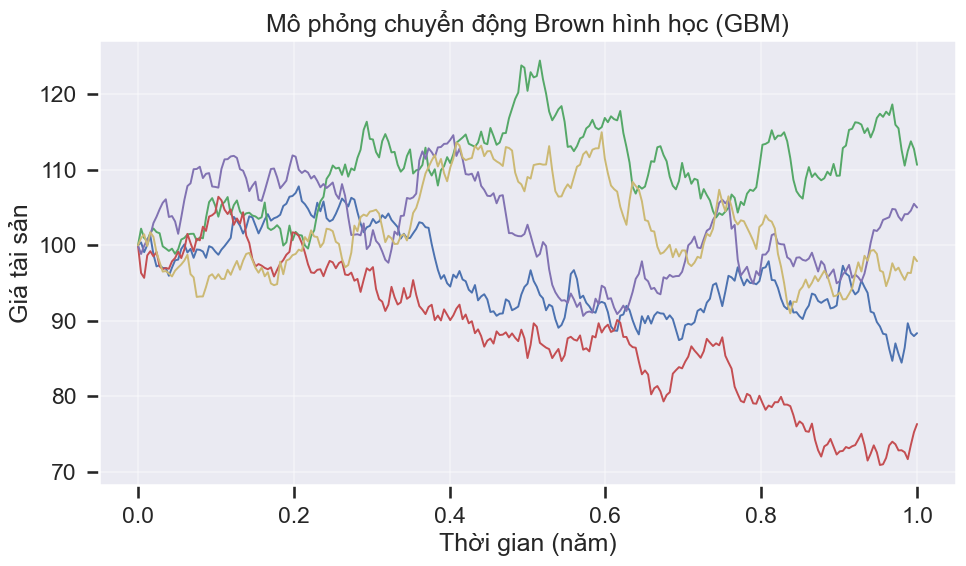

In [150]:
def simulate_gbm(paths, steps, S0, r, sigma, dt, seed=RNG_SEED):
    """Mô phỏng GBM: S_{t+dt} = S_t * exp((r-σ²/2)dt + σ√dt·Z)."""
    rng = np.random.default_rng(seed)
    Z = rng.standard_normal((paths, steps))
    S = np.empty((paths, steps + 1))
    S[:, 0] = S0
    drift = (r - 0.5 * sigma**2) * dt
    vol   = sigma * np.sqrt(dt)
    for i in range(steps):
        S[:, i + 1] = S[:, i] * np.exp(drift + vol * Z[:, i])
    return S

S_paths = simulate_gbm(paths=paths, steps=steps, S0=S0, r=r, sigma=sigma, dt=dt, seed=RNG_SEED)

# Vẽ 5 đường đầu tiên cho trực quan
plt.figure(figsize=(10, 6))
for i in range(min(N_PLOT, paths)):
    plt.plot(time, S_paths[i], lw=1.4)
plt.title("Mô phỏng chuyển động Brown hình học (GBM)")
plt.xlabel("Thời gian (năm)")
plt.ylabel("Giá tài sản")
plt.grid(alpha=0.35)
plt.tight_layout()
plt.show()


Kết quả mô phỏng trên tạo ra một tập hợp các đường giá giả định cho tài sản cơ sở. Từ các đường giá này, ta có thể kiểm chứng cơ chế phòng hộ delta trong thực tế: liệu danh mục delta-neutral có thực sự triệt tiêu rủi ro hướng giá như lý thuyết mô hình BSM khẳng định hay không.

Tiếp theo, ta mô phỏng danh mục phòng hộ delta-neutral. Khi nắm giữ một quyền chọn call, nhà giao dịch sẽ bán khống $Δ$ cổ phiếu, còn phần tiền ròng được đầu tư với lãi suất phi rủi ro. Khi giá cơ sở thay đổi, hệ số delta cũng thay đổi theo, do đó danh mục cần được tái phòng hộ liên tục (hoặc gần liên tục). Mỗi bước thời gian mô phỏng tương ứng với một lần điều chỉnh danh mục.

C:\Users\admin\AppData\Local\Temp\ipykernel_33516\3007325988.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r - q + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
C:\Users\admin\AppData\Local\Temp\ipykernel_33516\3007325988.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r - q + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))


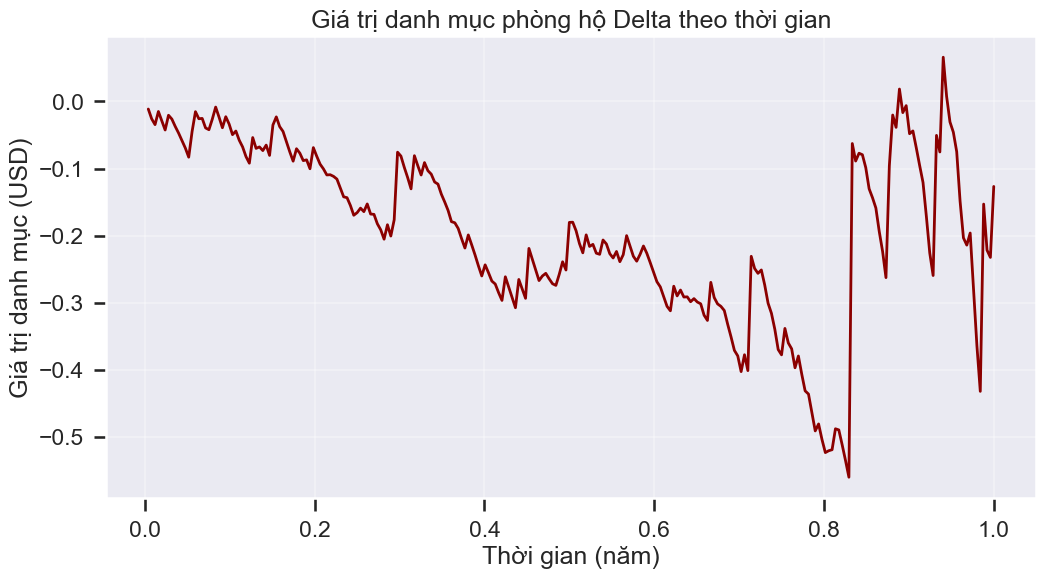

In [ ]:
# --- Khởi tạo danh mục Delta-neutral ---
shares = -delta(S_paths[0, 0], K, T, r, q, sigma, 0)
cash = -shares * S_paths[0, 0] - option_price(S_paths[0, 0], K, T, r, q, sigma, 0, 'Call')

portfolio_values = []

# --- Cập nhật danh mục theo thời gian ---
for i in range(1, len(time)):
    t = time[i]
    new_shares = -delta(S_paths[0, i], K, T, r, q, sigma, t)
    cash *= np.exp(r * dt)                        # Tích lũy tiền mặt với lãi suất r
    cash += (shares - new_shares) * S_paths[0, i] # Điều chỉnh vị thế cổ phiếu
    shares = new_shares
    V_port = cash + shares * S_paths[0, i] + option_price(S_paths[0, i], K, T, r, q, sigma, t, 'Call')
    portfolio_values.append(V_port)

# --- Vẽ kết quả ---
plt.figure(figsize=(12, 6))
plt.plot(time[1:], portfolio_values, lw=2, color='darkred')
plt.title("Giá trị danh mục phòng hộ Delta theo thời gian")
plt.xlabel("Thời gian (năm)")
plt.ylabel("Giá trị danh mục (USD)")
plt.grid(alpha=0.3)
plt.show()


Kết quả mô phỏng cho thấy: mặc dù giá tài sản cơ sở thay đổi liên tục theo thời gian, giá trị danh mục phòng hộ delta gần như không biến động đáng kể. 
Điều này minh họa trực quan cho phương trình (2): 

- phần thay đổi từ quyền chọn và bán khống cổ phiếu phần lớn triệt tiêu lẫn nhau, 

- phần còn lại là chi phí hoặc lợi nhuận nhỏ từ tài trợ và các hiệu ứng phi tuyến (gamma, theta).

Đây chính là nền tảng để mô hình Black–Scholes–Merton có thể định giá quyền chọn mà không cần dự báo hướng đi của giá cơ sở.

# IV. Khai triển Taylor và các hệ số Greek

Ở phần trước, chúng ta đã phân tích sự thay đổi giá trị danh mục phòng hộ delta qua ba thành phần: thay đổi giá trị quyền chọn, thay đổi giá trị vị thế bán khống, và chi phí vốn. Phần thay đổi giá trị quyền chọn, $C(S_{t+1}) - C(S_t)$, chính là phần quan trọng nhất về mặt mô hình hóa: nó phản ánh cách giá quyền chọn phản ứng với những biến động nhỏ trong giá của tài sản cơ sở và với sự trôi đi của thời gian.

Để mô tả một cách chính xác sự thay đổi này, ta sử dụng **khai triển Taylor** quanh điểm $S_t$​ — đây là một công cụ chuẩn trong toán tài chính để xấp xỉ biến động nhỏ. Ý tưởng cơ bản là giá quyền chọn $C$ là một hàm của hai biến: giá tài sản cơ sở $S$ và thời gian $t$. Khi $S$ thay đổi một lượng nhỏ và thời gian trôi đi một khoảng ngắn $\Delta t$, ta có thể khai triển sự thay đổi của $C$ theo chuỗi Taylor:

$$\Delta C \approx \frac{\partial C}{\partial S}(S_{t+1}-S_t) + \frac{1}{2}\frac{\partial^2 C}{\partial S^2}(S_{t+1}-S_t)^2 + \frac{\partial C}{\partial t}\Delta t. \tag{3}$$

Ba thành phần trong khai triển này lần lượt tương ứng với ba hệ số nhạy cảm của quyền chọn (Greek letters):

## 1. **Delta ($\Delta$)**:
$$\Delta = \frac{\partial C}{\partial S}$$

Đây là độ nhạy của giá quyền chọn đối với thay đổi nhỏ trong giá tài sản cơ sở. Nếu giá tài sản cơ sở tăng thêm 1 đơn vị, giá quyền chọn tăng xấp xỉ $\Delta$ đơn vị. Delta là cơ sở của việc thiết lập danh mục phòng hộ trung lập hướng giá.

## 2. **Gamma ($\Gamma$)**: 
$$\Gamma = \frac{\partial^2 C}{\partial S^2}$$

Gamma đo độ cong của hàm giá quyền chọn theo giá tài sản cơ sở. Trong khi delta cho biết độ dốc tại một điểm, gamma cho biết độ thay đổi của delta khi giá cơ sở biến động. Đây là yếu tố quyết định khả năng tạo lợi nhuận từ biến động (volatility) của một danh mục đã phòng hộ delta.

## 3. **Theta ($\theta$)**:
 $$\theta = \frac{\partial C}{\partial t}.$$

Theta đo tốc độ giảm giá trị của quyền chọn theo thời gian. Khi các yếu tố khác không đổi, quyền chọn mất giá dần khi thời gian trôi qua vì xác suất để quyền chọn trở nên có giá trị nội tại (in the money) giảm dần. Đây chính là chi phí thời gian (time decay) mà người mua quyền chọn phải gánh chịu.

Khi cộng thêm vị thế bán khống cổ phiếu $-\Delta (S_{t+1} - S_t)$ vào sự thay đổi giá trị quyền chọn, phần thay đổi do delta được triệt tiêu hoàn toàn. Điều này chính là mục tiêu của việc thiết lập danh mục phòng hộ delta. Phần còn lại của sự thay đổi giá trị danh mục chỉ bao gồm các tác động từ gamma, theta và chi phí vốn:

$$\Delta \Pi \approx \frac{1}{2}\Gamma (S_{t+1}-S_t)^2 + \theta \Delta t - r(C - \Delta S_t)\Delta t. \tag{4}$$

Phương trình (4) có thể hiểu theo nghĩa sau:

- **Thành phần gamma** đại diện cho ảnh hưởng của biến động giá cơ sở lên giá trị danh mục. Khi thị trường biến động, danh mục delta-neutral thu được lợi nhuận từ hiệu ứng gamma.
    
- **Thành phần theta** phản ánh tổn thất giá trị do thời gian trôi qua.
    
- **Thành phần chi phí vốn** thể hiện lãi hoặc chi phí từ khoản tiền ròng khi thiết lập danh mục.
    

Cần nhấn mạnh rằng phương trình này được xây dựng dựa trên giả định bước thời gian $\Delta t$ là rất nhỏ. Điều này đảm bảo rằng:

- Phần thay đổi bậc nhất theo giá được triệt tiêu nhờ phòng hộ delta.
    
- Các thành phần bậc cao hơn (từ bậc ba trở lên trong khai triển Taylor) có thể được bỏ qua vì giá trị của chúng là không đáng kể trong giới hạn ngắn hạn.

**Ví dụ:**  
Giả sử gamma của quyền chọn là $\Gamma = 0,02$ và giá tài sản cơ sở tăng hoặc giảm 1 USD ($\Delta S = 1$). Khi đó, phần thay đổi giá trị quyền chọn do gamma là:

$$\frac{1}{2} \times 0,02 \times (1)^2 = 0,01 \ \text{USD}$$

Khoản lợi nhuận nhỏ này phát sinh hoàn toàn từ độ cong của hàm giá quyền chọn và hoàn toàn độc lập với hướng tăng hay giảm của giá tài sản cơ sở. Chính điều này giải thích tại sao danh mục trung lập delta có thể tạo ra lợi nhuận từ biến động mà không cần dự đoán hướng thị trường.

Phân tích trên cho thấy rằng các hệ số Greek không phải là những ký hiệu kỹ thuật đơn thuần. Chúng phản ánh trực tiếp cấu trúc tài chính bên trong của quyền chọn. Khi nhà giao dịch hiểu và kiểm soát được delta, gamma và theta, họ có thể thiết kế các chiến lược giao dịch phức tạp mà vẫn kiểm soát được rủi ro cơ bản. Đặc biệt, gamma và theta đóng vai trò cốt lõi trong việc định giá và giao dịch dựa trên biến động, là nội dung trung tâm trong mô hình BSM.

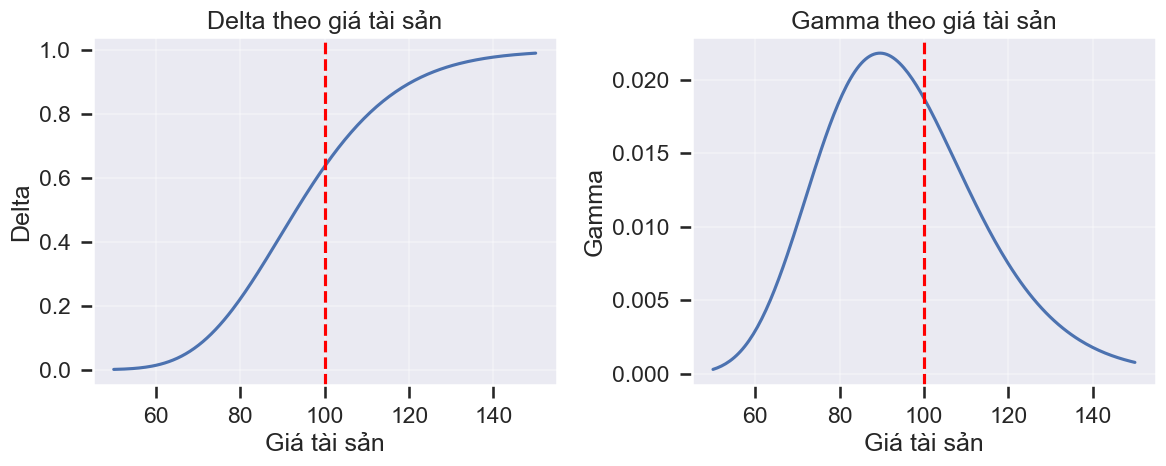

In [ ]:
S_range = np.linspace(50, 150, 200)
delta_vals = delta(S_range, K, T, r, q, sigma, 0)
gamma_vals = gamma(S_range, K, T, r, q, sigma, 0)

plt.figure(figsize=(12, 5))

# Delta
plt.subplot(1, 2, 1)
plt.plot(S_range, delta_vals)
plt.axvline(K, color='r', linestyle='--')
plt.title("Delta theo giá tài sản")
plt.xlabel("Giá tài sản")
plt.ylabel("Delta")
plt.grid(alpha=0.3)

# Gamma
plt.subplot(1, 2, 2)
plt.plot(S_range, gamma_vals)
plt.axvline(K, color='r', linestyle='--')
plt.title("Gamma theo giá tài sản")
plt.xlabel("Giá tài sản")
plt.ylabel("Gamma")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Kết quả cho thấy Delta của quyền chọn call tăng dần từ gần 0 (deep out-of-the-money) lên gần 1 (deep in-the-money). Điểm uốn lớn nhất nằm quanh giá thực hiện (strike), chính là vùng mà quyền chọn nhạy cảm nhất với biến động giá cơ sở.

Gamma đạt cực đại ở vùng giá thực hiện, thể hiện độ cong lớn nhất của hàm giá quyền chọn. Đây cũng chính là khu vực mà danh mục phòng hộ delta dễ bị “mất cân bằng” nhất và cần tái phòng hộ thường xuyên.

# V. Cấu trúc lợi nhuận của danh mục

Sau khi đã thiết lập danh mục trung lập delta và mô tả cách giá trị của danh mục thay đổi theo thời gian ngắn thông qua khai triển Taylor, ta có thể rút gọn sự thay đổi giá trị của danh mục thành ba thành phần chính: ảnh hưởng từ biến động giá cơ sở (gamma), ảnh hưởng của thời gian (theta) và ảnh hưởng từ dòng tiền tài trợ (financing).

Kết quả đã được trình bày ở phương trình (4):

$$\Delta \Pi \approx \frac{1}{2}\Gamma (S_{t+1}-S_t)^2 + \theta \Delta t - r(C - \Delta S_t)\Delta t. \tag{4}$$

Mỗi thành phần trong phương trình này có một ý nghĩa tài chính riêng biệt và đóng một vai trò khác nhau trong cơ chế định giá quyền chọn.

## 1. Thành phần gamma: lợi nhuận từ biến động

Thành phần:

$$\frac{1}{2}\Gamma (S_{t+1}-S_t)^2$$

Phản ánh lợi nhuận hoặc thua lỗ của danh mục do độ cong của giá quyền chọn theo giá tài sản cơ sở.

Điểm đáng chú ý là biểu thức này phụ thuộc vào **bình phương** của độ thay đổi giá cơ sở. Do đó, nó **không phụ thuộc vào hướng đi của giá** mà chỉ phụ thuộc vào **mức độ biến động**. Đây là lý do tại sao nhà giao dịch nắm giữ một danh mục trung lập delta có thể thu lợi từ biến động giá mà không cần dự đoán giá sẽ tăng hay giảm.

Để hiểu rõ bản chất thống kê của phần lợi nhuận gamma, ta cần xem xét đặc điểm phân phối của biến động giá cơ sở trong mô hình Black–Scholes–Merton. 
Vì giá tài sản được giả định tuân theo chuyển động Brown hình học, nên lợi suất ngắn hạn $frac{S_{t+1}-S_t}{S_t}$ sẽ xấp xỉ phân phối chuẩn. 
Điều này là chìa khóa để tính kỳ vọng của bình phương biến động giá và xác định lợi nhuận gamma kỳ vọng.



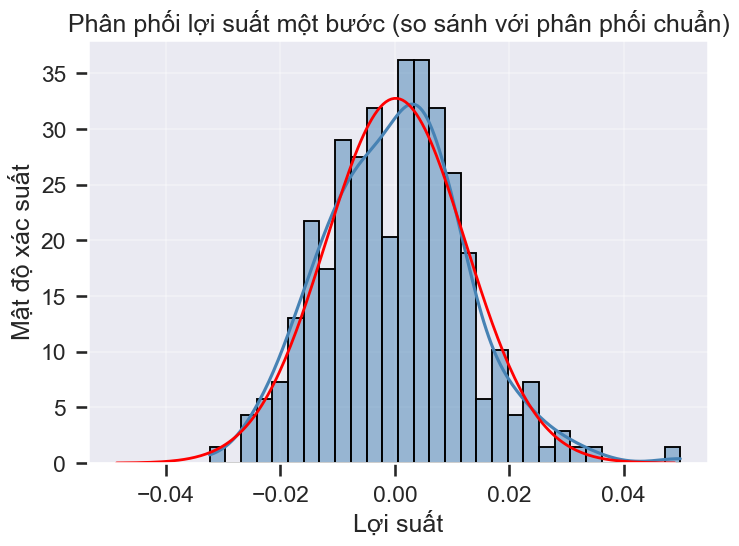

In [ ]:
# --- Histogram phân phối lợi suất 1 bước ---
returns = (S_paths[:, 1:] - S_paths[:, :-1]) / S_paths[:, :-1]
mean_step = np.mean(returns[0])
std_step = np.std(returns[0])
x = np.linspace(mean_step - 4 * std_step, mean_step + 4 * std_step, 200)

sns.histplot(returns[0], bins=30, stat="density", kde=True, color='steelblue')
plt.plot(x, ss.norm.pdf(x, mean_step, std_step), 'r', lw=2)
plt.title("Phân phối lợi suất một bước (so sánh với phân phối chuẩn)")
plt.xlabel("Lợi suất")
plt.ylabel("Mật độ xác suất")
plt.grid(alpha=0.3)
plt.show()


Biểu đồ trên cho thấy lợi suất mô phỏng có dạng xấp xỉ phân phối chuẩn, đúng như giả định nền tảng của mô hình BSM. 
Chính đặc tính này giúp ta dễ dàng tính $\mathbb{E}[(S_{t+1}-S_t)^2]$ — tức phương sai của biến động giá — và từ đó xác định lợi nhuận kỳ vọng từ thành phần gamma trong phương trình (4).



Nếu gamma của quyền chọn là dương (điều thường đúng với người mua quyền chọn call hoặc put), danh mục phòng hộ delta sẽ có lợi khi thị trường có biến động mạnh. Khi giá tăng, quyền chọn tăng giá nhiều hơn mức lỗ từ bán khống cổ phiếu; khi giá giảm, quyền chọn giảm giá ít hơn mức lãi từ bán khống. Cả hai hướng đều đem lại kết quả có lợi nhờ độ cong của hàm giá quyền chọn.

## 2. Thành phần theta: chi phí thời gian

Thành phần:

$$\theta \Delta t$$

Phản ánh sự mất giá trị của quyền chọn theo thời gian, trong khi các yếu tố khác được giữ nguyên. Khi thời gian trôi đi, quyền chọn trở nên ít có khả năng được thực hiện với giá trị nội tại dương. Do đó, giá trị thời gian của quyền chọn giảm dần theo tốc độ được đo bằng hệ số theta.

Đối với người nắm giữ quyền chọn, theta thường là âm: danh mục mất giá trị theo thời gian. Ngược lại, người bán quyền chọn sẽ hưởng lợi từ sự giảm giá trị này. Đây là lý do vì sao nhiều chiến lược giao dịch quyền chọn được xây dựng xoay quanh việc “mua gamma” (hưởng lợi từ biến động) đồng thời “trả theta” (chịu chi phí thời gian).

## 3. Thành phần tài chính: chi phí hoặc lãi từ dòng tiền

Thành phần:

$$- r (C - \Delta S_t) \Delta t$$

Thể hiện chi phí hoặc lãi từ việc tài trợ danh mục. Khi bán khống cổ phiếu để mua quyền chọn, nhà giao dịch có thể có một khoản tiền ròng dương hoặc âm. Khoản này được giả định đầu tư hoặc đi vay ở lãi suất phi rủi ro $r$.

Nếu tiền ròng là dương, ta có thêm một khoản lãi tài chính; nếu âm, đó là chi phí vốn. Thành phần này đóng vai trò như một lực điều chỉnh, đảm bảo rằng giá quyền chọn phản ánh đúng chi phí cơ hội của vốn trong mô hình không arbitrage.

## 4. Điều kiện cân bằng không arbitrage

Vì danh mục đã được phòng hộ delta, nên về nguyên tắc nó **không còn rủi ro hướng giá** trong khoảng thời gian ngắn. Theo lập luận không có cơ hội arbitrage, một danh mục không rủi ro phải có lợi nhuận kỳ vọng bằng 0 sau khi tính đến chi phí vốn. Điều này dẫn đến điều kiện cân bằng:

$$\frac{1}{2}\Gamma \mathbb{E}[(S_{t+1}-S_t)^2] + \theta - r(C - \Delta S_t) = 0. \tag{5}$$

Phương trình (5) chính là biểu thức tài chính cốt lõi dẫn tới phương trình định giá BSM. Ở đây:

- Thành phần gamma thể hiện lợi nhuận kỳ vọng từ biến động giá,
    
- Thành phần theta thể hiện sự mất giá trị theo thời gian,
    
- Thành phần tài chính đảm bảo tính nhất quán với lãi suất phi rủi ro.

Công bằng về lợi nhuận trong phương trình này chính là điều kiện cần để loại bỏ arbitrage. Nếu phương trình không thỏa mãn, một nhà giao dịch có thể thiết lập danh mục trung lập delta và tạo ra lợi nhuận phi rủi ro — điều không thể xảy ra trong một thị trường hiệu quả.

## 5. Ý nghĩa tài chính tổng quát

Phân tích ba thành phần lợi nhuận này cho thấy rằng:

- **Gamma** là nguồn tạo lợi nhuận từ biến động (volatility),
    
- **Theta** là chi phí thời gian không thể tránh khỏi,
    
- **Chi phí vốn** là thành phần tài chính điều chỉnh để duy trì cân bằng.

Cấu trúc lợi nhuận này không chỉ là nền tảng của mô hình định giá BSM mà còn là cơ sở cho nhiều chiến lược giao dịch quyền chọn trong thực tế. Thay vì đặt cược vào hướng di chuyển của giá tài sản cơ sở, các nhà giao dịch chuyên nghiệp quản lý và khai thác ba thành phần này một cách có hệ thống: họ có thể “mua gamma”, “bán theta” hoặc điều chỉnh cấu trúc tài trợ để đạt được kết quả lợi nhuận mong muốn.

Nói cách khác, phương trình (5) là chiếc cầu nối giữa mô hình toán học của quyền chọn và cách nó được giao dịch thực tế trên thị trường. Từ đây, ta có thể tiến tới các bước tiếp theo: liên hệ phương sai của giá tài sản cơ sở với độ biến động, và dẫn xuất phương trình BSM hoàn chỉnh.

---



# VI. Liên hệ với độ biến động

Từ điều kiện cân bằng không arbitrage đã được thiết lập ở phần trước, ta có phương trình cơ bản mô tả kỳ vọng thay đổi giá trị của một danh mục phòng hộ delta trong một khoảng thời gian ngắn:

$$\frac{1}{2}\Gamma \mathbb{E}[(S_{t+1}-S_t)^2] + \theta - r(C - \Delta S_t) = 0. \tag{5}$$

Phương trình này có một ý nghĩa then chốt: nó cho thấy rằng lợi nhuận kỳ vọng của danh mục không còn phụ thuộc vào hướng dịch chuyển của giá tài sản cơ sở, mà chỉ còn phụ thuộc vào **phương sai của sự thay đổi giá**. Khi ta xem xét một khoảng thời gian đủ nhỏ, yếu tố quyết định nằm ở độ lớn của biến động — chứ không phải ở chiều hướng tăng hay giảm của giá. Đây là điểm khác biệt căn bản giữa cách tiếp cận trong định giá quyền chọn và cách dự báo truyền thống.

Trong mô hình BSM, biến động giá của tài sản cơ sở được mô tả như một quá trình ngẫu nhiên liên tục. Kỳ vọng phương sai của sự thay đổi giá trong một khoảng thời gian ngắn được viết:

$$\mathbb{E}[(S_{t+1}-S_t)^2] = \sigma^2 S_t^2 \Delta t, \tag{6}$$

trong đó $\sigma$ là độ biến động (volatility) của tài sản cơ sở. Khi thay phương trình (6) vào điều kiện cân bằng (5), ta thu được:

$$\frac{1}{2}\sigma^2 S_t^2 \Gamma + \theta - r(C - \Delta S_t) = 0. \tag{7}$$

Phương trình (7) có thể xem như một dạng rút gọn của phương trình định giá BSM. Điều quan trọng cần nhấn mạnh ở đây là: **drift (tức tốc độ tăng trưởng kỳ vọng của giá tài sản cơ sở)** hoàn toàn biến mất khỏi công thức. Đây không phải là kết quả tình cờ, mà là hệ quả tất yếu của việc xây dựng một danh mục trung lập delta. Khi delta được triệt tiêu, lợi nhuận kỳ vọng của danh mục không còn chịu ảnh hưởng của xu hướng giá, mà chỉ còn phản ánh độ bất định của chuyển động giá — tức độ biến động. Vì thế, mô hình BSM không yêu cầu người định giá phải có quan điểm về thị trường tăng hay giảm. Tất cả những gì quan trọng là mức độ biến động mà thị trường kỳ vọng.

Cách tiếp cận này thể hiện một bước ngoặt quan trọng trong tư duy tài chính. Thay vì xây dựng mô hình dựa trên các giả định về xu hướng tăng trưởng của tài sản cơ sở, mô hình định giá quyền chọn dựa vào **rủi ro ngẫu nhiên**, cụ thể là phương sai của biến động. Khi thị trường càng biến động, xác suất quyền chọn đạt được giá trị nội tại càng cao, kéo theo giá quyền chọn tăng lên. Ngược lại, khi thị trường ít biến động, xác suất này giảm và giá quyền chọn rẻ hơn. Vì vậy, độ biến động đóng vai trò như một biến số quyết định trong việc định giá.

Để minh họa ý nghĩa thực tiễn của phương trình (7), giả sử độ biến động của tài sản cơ sở là $\sigma = 0,2$ (tức 20%/năm), giá tài sản $S_t$ = 100 USD, gamma của quyền chọn là $\Gamma = 0,02$ và ta xét một ngày giao dịch ($\Delta t$ = 1/365 năm). Khi đó:

$$\frac{1}{2} \times 0,2^2 \times 100^2 \times 0,02 \times \frac{1}{365} \approx 0,022 \ \text{USD}.$$

Khoản này chính là phần lợi nhuận kỳ vọng phát sinh từ gamma khi có biến động giá trong ngày, bất kể giá tài sản tăng hay giảm. Nó phản ánh trực tiếp mối liên hệ giữa biến động giá của tài sản cơ sở và lợi nhuận kỳ vọng của danh mục phòng hộ delta.

Từ góc độ mô hình hóa, phương trình (7) là một bước quan trọng trong việc dẫn xuất phương trình BSM hoàn chỉnh. Nó cho phép ta loại bỏ yếu tố drift, cô lập tác động của volatility, và nhấn mạnh rằng giá quyền chọn là kết quả của sự đánh đổi giữa lợi nhuận từ gamma, chi phí thời gian (theta) và chi phí tài trợ vốn. Từ góc độ thị trường, phương trình này cũng giải thích vì sao giá quyền chọn thường tăng khi độ biến động thị trường tăng — ngay cả khi giá tài sản cơ sở không có xu hướng rõ rệt. Độ biến động cao đồng nghĩa với rủi ro lớn hơn và cơ hội để quyền chọn trở nên có giá trị nội tại cũng lớn hơn.

Tóm lại, phần này cho thấy rõ rằng mô hình BSM không định giá quyền chọn dựa trên kỳ vọng tăng giá hay giảm giá của tài sản cơ sở, mà dựa trên mức độ bất định xung quanh chuyển động giá đó. Volatility, chứ không phải drift, là yếu tố chi phối. Đây chính là cơ sở lý thuyết sâu xa khiến implied volatility trở thành một trong những biến số được quan sát và giao dịch nhiều nhất trên thị trường quyền chọn toàn cầu.

---

# VII. Ứng dụng trong thực tiễn giao dịch

Cho đến đây, chúng ta đã xây dựng được cơ sở lý thuyết cốt lõi của mô hình định giá quyền chọn BSM. Từ một danh mục trung lập delta, thông qua lập luận không có cơ hội arbitrage và mối liên hệ giữa gamma, theta, chi phí vốn và độ biến động, ta có phương trình định giá rút gọn. Bước tiếp theo — cũng là phần quan trọng nhất đối với các nhà giao dịch thực tế — là chuyển từ mô hình lý thuyết sang cách ứng dụng nó trong hoạt động giao dịch quyền chọn hằng ngày.

Trong thực tiễn, mô hình BSM có hai cách sử dụng chủ đạo. Cách thứ nhất là **tính toán giá lý thuyết của quyền chọn khi biết hoặc ước lượng được độ biến động** của tài sản cơ sở trong tương lai. Cách thứ hai là **suy ngược độ biến động ngụ ý (implied volatility)** từ giá quyền chọn quan sát được trên thị trường, sau đó so sánh giá trị này với kỳ vọng riêng để xác định cơ hội giao dịch.

Ở trường hợp đầu tiên, giả sử nhà giao dịch có thể đưa ra một ước lượng về độ biến động kỳ vọng trong suốt thời hạn hiệu lực của quyền chọn, mô hình BSM sẽ cung cấp một giá lý thuyết tương ứng. Nếu giá thị trường của quyền chọn thấp hơn đáng kể giá lý thuyết này, nhà giao dịch có thể mua quyền chọn và kỳ vọng thu được lợi nhuận khi biến động thực tế hiện thực hóa. Ngược lại, nếu giá thị trường cao hơn giá lý thuyết, bán quyền chọn có thể là một lựa chọn hợp lý.

Ở trường hợp thứ hai, thường gặp hơn trong thực tế, độ biến động không phải là thứ được “đưa vào” mô hình mà là thứ được “rút ra”. Cụ thể, nhà giao dịch quan sát giá quyền chọn trên thị trường và giải phương trình BSM để tìm ra giá trị σ\sigmaσ khiến mô hình cho ra mức giá đó. Giá trị σ\sigmaσ này gọi là **độ biến động ngụ ý** (implied volatility). Nó không chỉ là một con số kỹ thuật: implied volatility là sự kết tinh của kỳ vọng thị trường về mức độ biến động trong tương lai.

Sự chênh lệch giữa volatility ngụ ý và volatility kỳ vọng (hoặc volatility thực tế được đo từ dữ liệu lịch sử) chính là nền tảng cho nhiều chiến lược giao dịch quyền chọn chuyên nghiệp. Nếu implied volatility thấp hơn volatility mà nhà giao dịch dự báo, việc mua quyền chọn kết hợp với phòng hộ delta sẽ có kỳ vọng lợi nhuận dương. Ngược lại, nếu implied volatility cao, bán quyền chọn có thể mang lại lợi thế vì người bán đang “bán đắt” quyền biến động.

Từ góc độ toán học, như đã thấy ở phần trước, phần lợi nhuận kỳ vọng phát sinh từ gamma trong một khoảng thời gian ngắn tỉ lệ với:

$$\frac{1}{2} S^2 (\sigma^2 - \sigma_{\text{implied}}^2), \tag{8}$$

trong đó $\sigma$ là volatility thực tế của tài sản cơ sở, còn $\sigma_{\text{implied}}$ là volatility ngụ ý được suy ra từ giá quyền chọn thị trường. Nếu $\sigma > \sigma_{\text{implied}}$​, tức biến động thực tế lớn hơn biến động thị trường “định giá”, danh mục delta-neutral mang lại lợi nhuận kỳ vọng dương. Đây là cơ sở trực tiếp cho các chiến lược “long volatility” thông qua quyền chọn.

Ý nghĩa của kết quả này rất sâu sắc. Nó cho thấy rằng quyền chọn không chỉ là công cụ để đặt cược vào hướng đi của thị trường, mà còn là công cụ để giao dịch chính **mức độ bất định** của thị trường. Trong nhiều trường hợp, nhà giao dịch không có hoặc không cần có quan điểm về việc giá tài sản sẽ tăng hay giảm; thay vào đó, họ chỉ cần có quan điểm về việc thị trường sẽ biến động mạnh hay yếu hơn mức mà thị trường đang ngụ ý.

Đây cũng là lý do tại sao volatility — đặc biệt là implied volatility — trở thành một biến số được giao dịch như một tài sản riêng biệt. Trên thực tế, nhiều nhà giao dịch chuyên nghiệp quan tâm đến biến động hơn là đến giá tài sản cơ sở. Họ có thể thực hiện các chiến lược như long gamma/short theta, calendar spreads, volatility arbitrage hoặc delta-hedged option trading mà không cần phải dự báo hướng thị trường.

Tóm lại, phần này cho thấy mô hình BSM không chỉ có giá trị về mặt lý thuyết mà còn là nền tảng cho một hệ thống các chiến lược giao dịch phái sinh tinh vi. Thay vì chỉ định giá quyền chọn như một sản phẩm tài chính thụ động, mô hình này mở ra khả năng giao dịch độ biến động — một yếu tố thị trường có tính thông tin cao, được sử dụng rộng rãi trong quản trị rủi ro, định giá tài sản phái sinh và đầu cơ chuyên nghiệp.

# VIII. Lợi nhuận từ chênh lệch volatility

Trong các phần trước, chúng ta đã thấy rằng độ biến động (volatility) là biến số trung tâm trong định giá quyền chọn. Giá quyền chọn tăng khi độ biến động tăng, và ngược lại. Trong thực tiễn giao dịch, điều này dẫn tới một nguyên lý quan trọng: nếu biến động thực tế của tài sản cơ sở khác biệt đáng kể so với biến động ngụ ý trong giá quyền chọn thị trường, nhà giao dịch có thể xây dựng một danh mục delta-neutral để thu lợi nhuận từ sự chênh lệch này mà không cần đặt cược vào hướng dịch chuyển của giá.

Giả sử σ\sigmaσ là độ biến động thực tế (realized volatility) của tài sản cơ sở trong suốt vòng đời của quyền chọn, và $\sigma_{\text{implied}}$​ là độ biến động ngụ ý (implied volatility) suy ra từ giá quyền chọn tại thời điểm giao dịch. Nếu nhà giao dịch mua quyền chọn khi $\sigma_{\text{implied}}$​ thấp hơn $\sigma$, và đồng thời thực hiện phòng hộ delta liên tục, phần lợi nhuận kỳ vọng từ danh mục này tỷ lệ thuận với chênh lệch giữa hai độ biến động. Cụ thể:

$$\text{Lợi nhuận kỳ vọng} \ \propto \ \frac{1}{2} S^2 (\sigma^2 - \sigma_{\text{implied}}^2). \tag{8}$$

Ý nghĩa của biểu thức này rất rõ ràng: nếu biến động thực tế lớn hơn biến động thị trường định giá, danh mục mang lại lợi nhuận dương; nếu ngược lại, nhà giao dịch sẽ chịu lỗ. Đây chính là cơ sở của các chiến lược “long volatility” (mua quyền chọn để hưởng lợi từ biến động) và “short volatility” (bán quyền chọn để thu phí bảo hiểm khi biến động thấp).

Một cách diễn giải khác là: thị trường quyền chọn định giá biến động thông qua implied volatility. Nếu nhà giao dịch có khả năng dự báo biến động thực tế tốt hơn thị trường, họ có thể kiếm lợi từ sai lệch định giá này. Đây là một trong những điểm khiến thị trường quyền chọn trở nên phong phú hơn nhiều so với thị trường cơ sở: thay vì chỉ giao dịch hướng giá, người tham gia có thể giao dịch **mức độ bất định của giá**.

Trong bối cảnh này, hai khái niệm đặc biệt quan trọng là **gamma** và **vega**. Gamma, như đã trình bày, đo độ cong của hàm giá quyền chọn và quyết định mức độ nhạy cảm của danh mục delta-neutral đối với biến động giá. Vega đo mức độ nhạy cảm của giá quyền chọn đối với thay đổi trong implied volatility. Hai đại lượng này gắn bó chặt chẽ với nhau trong việc xác định lợi nhuận thực tế từ chiến lược delta-hedged.

Nếu một quyền chọn được mua ở mức implied volatility $\sigma_{\text{implied}}$​ và ngay sau đó độ biến động ngụ ý tăng lên $\sigma$, phần lợi nhuận phát sinh từ sự thay đổi này xấp xỉ:

$$\text{P/L} \ \approx \ \text{vega} \times (\sigma - \sigma_{\text{implied}}). \tag{9}$$

Phần lợi nhuận này có thể hiểu là phần “định giá lại” của quyền chọn do thị trường kỳ vọng biến động cao hơn. Khi nhà giao dịch nắm giữ một vị thế quyền chọn và phòng hộ delta, bất kỳ thay đổi nào trong implied volatility cũng chuyển trực tiếp thành lợi nhuận hoặc thua lỗ thông qua hệ số vega.

Hai phương trình (8) và (9) phản ánh hai cách nhìn khác nhau nhưng thống nhất về lợi nhuận từ chiến lược delta-hedged: (8) mô tả lợi nhuận phát sinh theo thời gian khi biến động thực tế khác biến động ngụ ý ban đầu, còn (9) mô tả lợi nhuận tức thời khi implied volatility dịch chuyển. Trong giới giao dịch chuyên nghiệp, việc theo dõi và quản trị vega là một phần không thể thiếu khi triển khai các chiến lược giao dịch dựa trên biến động.

Để minh họa rõ hơn, giả sử một quyền chọn có vega bằng 50 USD, implied volatility tại thời điểm mua là 20% và sau đó tăng lên 22%. Khi đó:

$$\text{P/L} = 50 \times (0,22 - 0,20) = 10 \ \text{USD}.$$

Nếu nhà giao dịch giữ danh mục này qua thời gian và biến động thực tế duy trì ở mức cao, lợi nhuận tích lũy từ gamma sẽ tiếp tục gia tăng, trong khi chi phí thời gian (theta) và chi phí tài chính sẽ là những yếu tố cần được quản lý cẩn trọng.

Trong thực tế, các chiến lược giao dịch quyền chọn dựa trên chênh lệch độ biến động rất đa dạng: từ các vị thế đơn giản như long hoặc short quyền chọn riêng lẻ, đến các cấu trúc phức tạp như straddles, strangles, calendar spreads hoặc volatility arbitrage. Dù ở dạng nào, nguyên tắc nền tảng vẫn là giống nhau: lợi nhuận đến từ việc xác định và khai thác sự khác biệt giữa biến động thực tế và biến động ngụ ý.

Tóm lại, phần này khép lại mạch lập luận khởi đầu từ việc xây dựng một danh mục trung lập delta. Một khi rủi ro hướng giá đã được triệt tiêu, biến động trở thành biến số duy nhất quyết định giá trị quyền chọn theo thời gian. Nếu một nhà giao dịch có thể ước lượng chính xác hơn thị trường về độ biến động thực tế, họ có thể thiết lập những chiến lược mang lại lợi nhuận kỳ vọng dương mà không cần dự báo chiều hướng của giá tài sản cơ sở. Đây chính là một trong những ứng dụng thực tiễn quan trọng và mạnh mẽ nhất của mô hình BSM trong thị trường tài chính hiện đại.

---

## IX. Vega và lợi nhuận tuyến tính theo volatility

Trong phần trước, chúng ta đã xem xét lợi nhuận kỳ vọng của một danh mục delta-neutral khi có sự khác biệt giữa độ biến động thực tế và độ biến động ngụ ý. Ở phần này, ta đi sâu hơn vào vai trò của **vega**, tức hệ số đo độ nhạy của giá quyền chọn đối với thay đổi trong implied volatility, và cách nó liên hệ với gamma để hình thành cấu trúc lợi nhuận trong thời gian nắm giữ quyền chọn.

Hệ số vega được định nghĩa là:

$$\text{vega} = \frac{\partial C}{\partial \sigma}.$$

Đây là đại lượng cho biết khi implied volatility thay đổi 1 đơn vị (thường tính theo phần trăm), giá quyền chọn thay đổi bao nhiêu. Trong thực tiễn, vega là công cụ định lượng quan trọng giúp nhà giao dịch đo lường mức độ nhạy cảm của danh mục quyền chọn trước những dịch chuyển về kỳ vọng biến động của thị trường.

Giả sử một nhà giao dịch mua quyền chọn tại mức implied volatility $\sigma_{\text{implied}}$. Sau đó, thị trường điều chỉnh kỳ vọng biến động lên mức σ\sigmaσ. Khi đó, lợi nhuận tức thời của danh mục (bỏ qua các yếu tố khác) được xấp xỉ bằng:

$$\text{P/L} \ \approx \ \text{vega} \times (\sigma - \sigma_{\text{implied}}). \tag{9}$$

Phương trình này mô tả một cách trực tiếp cách implied volatility ảnh hưởng đến giá quyền chọn. Nếu implied volatility tăng, vị thế quyền chọn mua (long option) tạo ra lợi nhuận; nếu giảm, vị thế này chịu lỗ. Vì thế, vega là một trong những thông số trọng yếu được theo dõi sát sao trong giao dịch thực tế, đặc biệt khi thị trường biến động mạnh hoặc khi các sự kiện có khả năng làm thay đổi kỳ vọng biến động sắp xảy ra (ví dụ: công bố kết quả kinh doanh, sự kiện vĩ mô, biến động chính trị…).

Mối quan hệ giữa gamma và vega cũng có thể được biểu diễn dưới dạng:

$$\text{vega} = \sigma T S^2 \Gamma, \tag{10}$$

trong đó $T$ là thời gian còn lại đến đáo hạn. Công thức này cho thấy rằng vega và gamma không phải là hai đại lượng độc lập. Cả hai đều xuất phát từ cùng một cấu trúc cong của giá quyền chọn đối với giá tài sản cơ sở và độ biến động. Trong thực tế, quyền chọn có gamma lớn cũng thường có vega lớn — tức là vừa nhạy với biến động giá cơ sở, vừa nhạy với thay đổi kỳ vọng biến động.

Điểm đáng chú ý là trong khi gamma phản ánh **lợi nhuận phát sinh do biến động giá thực tế của tài sản cơ sở**, vega phản ánh **lợi nhuận phát sinh do thị trường điều chỉnh kỳ vọng về độ biến động trong tương lai**. Cả hai yếu tố này có thể hoạt động song song hoặc ngược chiều. Một chiến lược giao dịch dựa trên biến động hiệu quả cần xem xét đồng thời cả gamma và vega để có cái nhìn toàn diện về rủi ro và lợi nhuận.

Để hình dung rõ hơn mối quan hệ giữa vega và độ biến động ngụ ý, ta xem xét cách giá trị vega thay đổi theo mức $\sigma_{\text{implied}}$ khi các yếu tố khác được giữ cố định. Đoạn mã dưới đây mô phỏng đường cong vega theo $\sigma$:

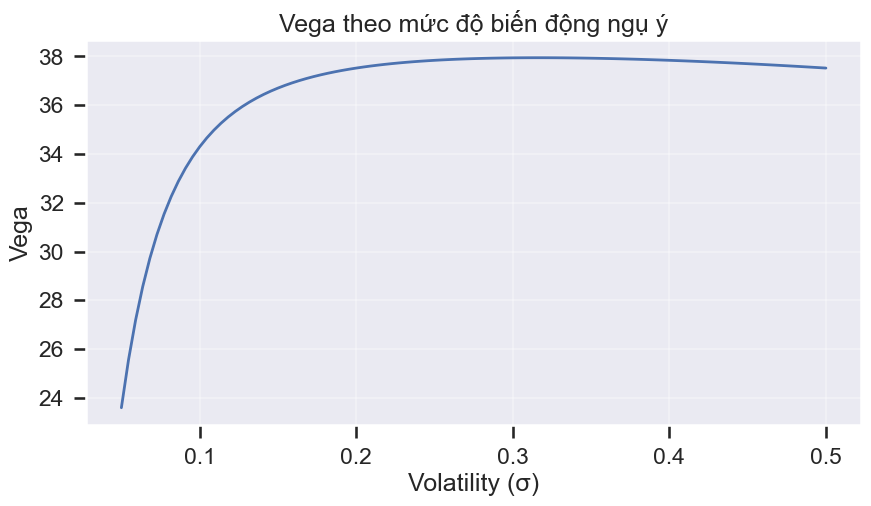

In [ ]:
# --- Vega theo volatility ---
sigma_values = np.linspace(0.05, 0.5, 100)
vega_curve = [vega(S0, K, T, r, q, s, 0) for s in sigma_values]

plt.figure(figsize=(10, 5))
plt.plot(sigma_values, vega_curve, lw=2)
plt.title("Vega theo mức độ biến động ngụ ý")
plt.xlabel("Volatility (σ)")
plt.ylabel("Vega")
plt.grid(alpha=0.3)
plt.show()



Đường cong trên cho thấy rằng vega đạt đỉnh tại một mức độ biến động trung bình — thường quanh vùng at-the-money. Khi volatility quá thấp hoặc quá cao, vega giảm xuống. Đây là lý do tại sao các quyền chọn at-the-money (ATM) có vega cao nhất, và vì thế cũng nhạy cảm nhất với những thay đổi trong kỳ vọng biến động của thị trường.

Ví dụ, giả sử một quyền chọn có vega bằng 50 USD. Nếu implied volatility tại thời điểm mua là 20% và sau đó tăng lên 22%, nhà giao dịch ghi nhận lợi nhuận tức thời:

$$\text{P/L} = 50 \times (0,22 - 0,20) = 10 \ \text{USD}.$$

Lợi nhuận này không đến từ sự thay đổi giá cơ sở mà đến từ sự điều chỉnh kỳ vọng thị trường về độ biến động. Nếu trong quá trình nắm giữ, biến động thực tế cũng cao hơn mức implied ban đầu, danh mục sẽ tiếp tục tích lũy lợi nhuận từ gamma.

Mặt khác, nếu implied volatility giảm thay vì tăng, lợi nhuận sẽ bị âm dù biến động thực tế có thể vẫn mang lại phần gamma dương. Đây chính là nguyên nhân khiến việc quản trị vega trở thành yếu tố trọng yếu trong giao dịch quyền chọn chuyên nghiệp: nó quyết định độ nhạy của danh mục đối với những thay đổi trong tâm lý thị trường về biến động tương lai.

Cần nhấn mạnh rằng các chiến lược giao dịch dựa trên chênh lệch độ biến động thực tế và implied volatility không chỉ là các chiến lược mang tính đầu cơ mà còn được sử dụng rộng rãi trong quản trị rủi ro. Các tổ chức tài chính lớn — chẳng hạn như ngân hàng đầu tư, quỹ phòng hộ hoặc nhà tạo lập thị trường — thường xây dựng những danh mục có gamma và vega được kiểm soát chặt chẽ để tránh bị tổn thương khi thị trường có những cú sốc biến động.

Tóm lại, vega là một mắt xích quan trọng trong toàn bộ cấu trúc định giá và giao dịch quyền chọn. Trong khi gamma xác định mức lợi nhuận từ biến động giá thực tế, vega quyết định mức lợi nhuận hoặc thua lỗ từ sự thay đổi trong kỳ vọng biến động. Mối quan hệ chặt chẽ giữa hai hệ số này tạo thành nền tảng để hiểu sâu về cách quyền chọn phản ứng với điều kiện thị trường, cũng như cách các nhà giao dịch chuyên nghiệp xây dựng và quản trị danh mục biến động một cách chiến lược.


X. Giới hạn của mô hình và thực tế triển khai

Mặc dù mô hình BSM là một trong những công cụ có ảnh hưởng sâu rộng nhất trong lịch sử tài chính hiện đại, nó vẫn là một mô hình lý tưởng hóa và do đó không thể mô tả hoàn toàn chính xác động lực thị trường thực tế. Những giả định được sử dụng để dẫn xuất phương trình BSM đã giúp mô hình trở nên đơn giản, đẹp và có thể giải tích, nhưng cũng đồng thời tạo ra những giới hạn nhất định khi áp dụng vào giao dịch và quản trị rủi ro trong thực tiễn.

Trước hết, mô hình BSM giả định rằng **giá tài sản cơ sở biến động liên tục** theo một chuyển động Brown hình học (geometric Brownian motion). Điều này có nghĩa là giá tài sản không có bước nhảy đột ngột, biến động diễn ra trơn tru và có thể được mô hình hóa hoàn toàn bằng phương trình vi phân ngẫu nhiên. Trong thực tế, thị trường tài chính thường xuyên xuất hiện những biến động đột biến — chẳng hạn như tin tức chính trị, sự kiện vĩ mô, cú sốc hệ thống hoặc hoạt động của các quỹ lớn. Những bước nhảy này làm cho giả định về chuyển động Brown liên tục trở nên thiếu thực tế, đặc biệt trong các giai đoạn khủng hoảng.

Thứ hai, mô hình BSM giả định rằng **độ biến động σ\sigmaσ là hằng số theo thời gian**. Đây có lẽ là một trong những giả định xa rời thực tế nhất. Trên thị trường, biến động thường thay đổi theo điều kiện kinh tế, trạng thái thị trường và kỳ vọng của nhà đầu tư. Không những thế, sự phân bố biến động còn thể hiện những đặc điểm không đối xứng (volatility skew hoặc smile), điều mà mô hình BSM cổ điển không giải thích được. Chính vì vậy, trong thực tế, các mô hình mở rộng như stochastic volatility hoặc jump-diffusion được sử dụng để khắc phục hạn chế này.

Thứ ba, mô hình BSM giả định **có thể giao dịch liên tục và không có chi phí giao dịch**. Theo mô hình, nhà giao dịch có thể phòng hộ danh mục bằng cách điều chỉnh vị thế delta liên tục theo thời gian mà không mất chi phí. Tuy nhiên, trong thực tế, mỗi lần điều chỉnh đều phải trả chi phí giao dịch và chịu ảnh hưởng của thanh khoản thị trường. Khi tần suất phòng hộ tăng cao, chi phí này trở thành một yếu tố đáng kể, làm xói mòn lợi nhuận kỳ vọng và khiến mô hình lý tưởng không còn hiệu quả.

Thứ tư, mô hình BSM giả định **không có giới hạn bán khống và thị trường vốn hoàn hảo**. Người tham gia có thể vay và cho vay không giới hạn tại cùng một lãi suất phi rủi ro rrr. Trong thực tế, chi phí vay mượn thường không đối xứng, khả năng bán khống bị giới hạn bởi quy định, và mức độ thanh khoản không đồng đều. Tất cả những yếu tố này đều có thể ảnh hưởng đáng kể đến việc triển khai một chiến lược delta-hedged thực tế.

Cuối cùng, mô hình BSM không tính đến **rủi ro mô hình (model risk)** và những yếu tố hành vi của thị trường. Các hiện tượng như panic selling, short squeeze, hoặc sự thay đổi bất ngờ trong tâm lý thị trường có thể dẫn đến những biến động mà mô hình BSM không thể dự đoán hoặc định giá chính xác. Hơn nữa, các mô hình này vốn dựa trên kỳ vọng toán học trung bình, trong khi các sự kiện cực đoan (tail events) lại có ảnh hưởng bất cân xứng đến kết quả giao dịch thực tế.

Những giới hạn trên không phủ nhận giá trị của mô hình BSM, mà giúp ta hiểu rõ phạm vi áp dụng hợp lý của nó. Trong giới tài chính chuyên nghiệp, BSM không được xem là một “sự thật tuyệt đối”, mà là một **điểm khởi đầu chuẩn hóa** để định giá quyền chọn và giao dịch biến động. Từ khung mô hình cơ bản này, nhiều mô hình mở rộng đã được phát triển để phản ánh tốt hơn thực tế thị trường, chẳng hạn như mô hình độ biến động ngẫu nhiên (stochastic volatility), mô hình bước nhảy (jump-diffusion), hoặc các mô hình cấu trúc vi mô thị trường.

Trên thực tế, phân phối lợi suất của tài sản tài chính hiếm khi tuân theo phân phối chuẩn lý tưởng mà mô hình BSM giả định. Các dữ liệu thực thường thể hiện hiện tượng đuôi dày (fat tails) và độ lệch phân phối (skewness) — phản ánh khả năng xảy ra các cú sốc thị trường cao hơn nhiều so với giả định chuẩn. Đoạn mã dưới đây minh họa sự khác biệt này thông qua histogram lợi suất:


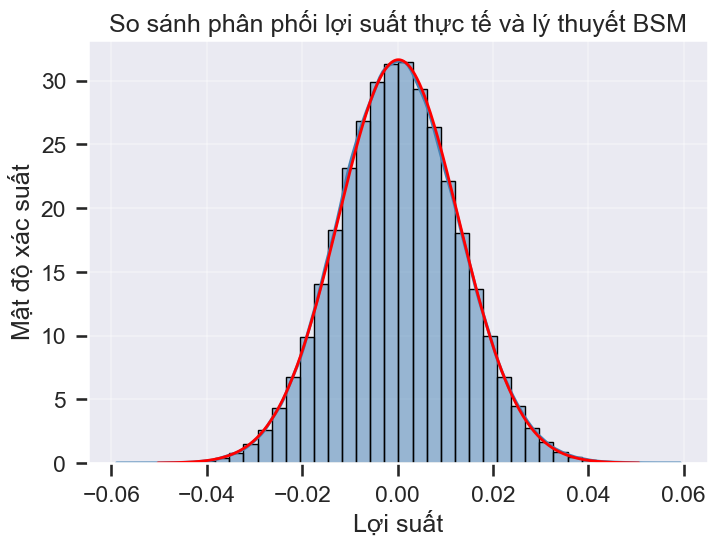

Skewness (độ lệch): 0.035657822513677336
Kurtosis (độ nhọn): -0.004549724671581767


In [ ]:
# --- Histogram toàn bộ lợi suất ---
ret_all = returns.flatten()
mean_all = np.mean(ret_all)
std_all = np.std(ret_all)
x = np.linspace(mean_all - 4 * std_all, mean_all + 4 * std_all, 400)

sns.histplot(ret_all, stat='density', bins=40, kde=True, color='steelblue')
plt.plot(x, ss.norm.pdf(x, mean_all, std_all), 'r', lw=2)
plt.title("So sánh phân phối lợi suất thực tế và lý thuyết BSM")
plt.xlabel("Lợi suất")
plt.ylabel("Mật độ xác suất")
plt.grid(alpha=0.3)
plt.show()

print("Skewness (độ lệch):", skew(ret_all))
print("Kurtosis (độ nhọn):", kurtosis(ret_all))



Kết quả histogram và các hệ số thống kê cho thấy lợi suất thực tế có độ lệch (skewness) và độ nhọn (kurtosis) khác 0 — tức là phân phối không hoàn toàn chuẩn. Đặc biệt, kurtosis dương phản ánh sự tồn tại của những sự kiện cực đoan (extreme events) có xác suất cao hơn so với giả định Gaussian.

Tóm lại, BSM là một công cụ lý thuyết có giá trị đặc biệt vì tính đơn giản, khả năng tính toán chính xác và khả năng cung cấp một khung tư duy rõ ràng về mối quan hệ giữa giá quyền chọn và biến động. Tuy nhiên, để áp dụng hiệu quả trong thực tế, nhà giao dịch và nhà quản trị rủi ro phải nhận thức đầy đủ những giới hạn này, điều chỉnh mô hình hoặc bổ sung các yếu tố thực tế nhằm xây dựng chiến lược phù hợp hơn với điều kiện thị trường phức tạp. Chính sự hiểu biết về giới hạn của mô hình — chứ không chỉ việc nắm bắt công thức — mới là yếu tố phân biệt giữa một người sử dụng mô hình BSM thành thạo và một người chỉ áp dụng cơ học.

# XI. Kết luận

Mô hình Black–Scholes–Merton model ra đời vào đầu thập niên 1970 đã mở ra một kỷ nguyên hoàn toàn mới trong lĩnh vực tài chính định lượng. Từ một ý tưởng có vẻ đơn giản — xây dựng một danh mục phòng hộ delta để loại bỏ rủi ro hướng giá — mô hình đã phát triển thành một khung định giá lý thuyết vững chắc cho quyền chọn và nhiều công cụ phái sinh khác. Không chỉ dừng lại ở mức độ mô hình toán học, BSM đã trở thành một chuẩn mực định giá được sử dụng toàn cầu và là nền tảng cho hàng loạt mô hình tài chính hiện đại.

Cốt lõi của mô hình BSM nằm ở tư duy tách biệt rủi ro biến động khỏi rủi ro hướng giá. Bằng cách bán khống một lượng tài sản cơ sở đúng bằng hệ số delta của quyền chọn, ta có thể xây dựng một danh mục trung lập hướng giá. Khi đó, sự thay đổi giá trị danh mục không còn phụ thuộc vào việc tài sản cơ sở tăng hay giảm, mà chỉ còn phụ thuộc vào độ lớn của biến động và thời gian trôi qua. Chính lập luận này đã dẫn đến phương trình cân bằng không arbitrage, trong đó drift của giá tài sản cơ sở bị triệt tiêu hoàn toàn. Đây là bước ngoặt quan trọng, giúp mô hình hóa giá quyền chọn dựa trên rủi ro ngẫu nhiên (volatility) thay vì kỳ vọng tăng trưởng (expected return).

Trong mô hình này, ba yếu tố — gamma, theta và chi phí tài trợ vốn — đóng vai trò cấu thành sự thay đổi giá trị danh mục. Gamma thể hiện lợi nhuận kỳ vọng từ biến động giá, theta thể hiện tổn thất từ sự trôi đi của thời gian, và chi phí tài trợ vốn đảm bảo sự nhất quán với lãi suất phi rủi ro. Khi kết hợp với kỳ vọng phương sai của biến động giá, ta dẫn xuất được phương trình định giá BSM, từ đó xác định giá quyền chọn một cách duy nhất trong điều kiện không arbitrage.

Tuy nhiên, điều làm cho mô hình BSM trở nên đặc biệt không chỉ là công thức định giá, mà là khung tư duy mà nó mang lại. Trong thực tế giao dịch, mô hình này cho phép nhà đầu tư:

- Tính toán giá lý thuyết của quyền chọn khi có ước lượng về độ biến động tương lai.
    
- Suy ngược độ biến động ngụ ý từ giá quyền chọn thị trường để đánh giá kỳ vọng của thị trường.
    
- Thiết lập các chiến lược giao dịch delta-neutral để khai thác chênh lệch giữa biến động thực tế và biến động ngụ ý.
    
- Đo lường và quản lý rủi ro danh mục thông qua các hệ số Greek như delta, gamma và vega.
    

Đặc biệt, việc implied volatility trở thành một biến số được giao dịch trực tiếp trên thị trường chính là hệ quả thực tiễn quan trọng của mô hình này. Thay vì chỉ đặt cược vào hướng di chuyển của giá tài sản cơ sở, các nhà giao dịch có thể đặt cược vào mức độ bất định của thị trường. Điều này đã dẫn đến sự ra đời và phát triển mạnh mẽ của các chiến lược và sản phẩm tài chính dựa trên biến động, từ quyền chọn truyền thống cho đến các sản phẩm phái sinh phức tạp hơn.

Tuy vậy, mô hình BSM cũng có những giới hạn rõ ràng. Các giả định lý tưởng như biến động không đổi, không có chi phí giao dịch, khả năng phòng hộ liên tục và thị trường hoàn hảo đều không hoàn toàn phù hợp với thực tế. Thị trường tài chính thực chất biến động phức tạp hơn nhiều, với những cú sốc, sự thay đổi kỳ vọng và giới hạn thanh khoản. Chính vì vậy, BSM thường được xem như một điểm khởi đầu, một “ngôn ngữ chung” để từ đó các mô hình mở rộng — như stochastic volatility, jump-diffusion, hay các mô hình cấu trúc vi mô — được phát triển nhằm phản ánh chính xác hơn hành vi thị trường.

Tóm lại, mô hình BSM không chỉ là một công cụ định giá quyền chọn. Nó là một phương pháp tư duy giúp nhà đầu tư và nhà quản lý rủi ro nhìn nhận các công cụ phái sinh theo cách cấu trúc: tách biệt rủi ro, lượng hóa ảnh hưởng của biến động, và xác định mức giá hợp lý thông qua điều kiện không arbitrage. Sự ra đời của mô hình này đã thay đổi tận gốc cách thị trường tài chính vận hành, giúp chuyển dịch từ trực giác giao dịch sang mô hình hóa định lượng. Dù thị trường ngày nay đã vượt xa khuôn khổ ban đầu của mô hình, tầm ảnh hưởng của BSM vẫn còn nguyên vẹn: mọi mô hình định giá quyền chọn hiện đại, ở mức độ này hay khác, đều bắt đầu từ nền tảng mà BSM đã đặt ra.

---

**Tài liệu tham khảo:**

- Hull, J. C. (2005). _Options, Futures, and Other Derivatives._
    
- Sinclair, E. (2010). _Volatility Trading._
    
- Black, F. and Scholes, M. (1973). _The Pricing of Options and Corporate Liabilities._
    
- Merton, R. C. (1973). _Theory of Rational Option Pricing._
    
